In [103]:
import pandas as pd
from utils.graph import KGraphPreproc
from utils.preprocessing import preprocess_text
import networkx as nx

## Given a question, and top relevant triplets to this point, predict next links

TODO:
1. Construct an incremental dataset (q, entity_level_1.2.3..., next_link)

In [104]:
fbkb_graph = KGraphPreproc.get_fbkb_graph()

In [105]:
len(fbkb_graph._graph.nodes())

14541

In [25]:
mid2name = pd.read_csv("/datasets/FB15k-237/mid2name.txt", sep="\t", header=None)
mid2name_dict = dict(zip(mid2name[0], mid2name[1]))
name2mid_dict = dict(zip(mid2name[1], mid2name[0]))
# 
fbkb = pd.DataFrame()
for split in ["train", "valid", "test"]:
    path = f"/datasets/FB15k-237/{split}.txt"
    split_df = pd.read_csv(path, sep="\t", header=None)
    fbkb = pd.concat([fbkb, split_df])
fbkb.rename(columns={0: "subject", 1: "relation", 2: "object"}, inplace=True)

In [26]:
fbkb.head()

,subject,relation,object
0,/m/027rn,/location/country/form_of_government,/m/06cx9
1,/m/017dcd,/tv/tv_program/regular_cast./tv/regular_tv_app...,/m/06v8s0
2,/m/07s9rl0,/media_common/netflix_genre/titles,/m/0170z3
3,/m/01sl1q,/award/award_winner/awards_won./award/award_ho...,/m/044mz_
4,/m/0cnk2q,/soccer/football_team/current_roster./sports/s...,/m/02nzb8


In [27]:
fbqa = pd.read_json("/datasets/FreebaseQA/FreebaseQA-eval.json")
def get_fbqa_data(question_row):
    """
    Takes in a dataset row and returns Q and A as strings
    """
    question = question_row.Questions.get("RawQuestion", None)
    parse = question_row.Questions.get("Parses", [None])[0]
    if not parse:
        print(f"error in question: {question}")
        return question, None
    answer = parse.get("Answers")
    return question, answer

In [88]:
lipr_df = pd.DataFrame(columns=["id", "question", "topic_entity", "answer_entity"], data=[[0, 0, 0, 0]])

In [89]:
for i, r in fbqa.iterrows():
    question = r.Questions.get("RawQuestion")
    for parse in r.Questions["Parses"]:
        parse_id = parse.get("Parse-Id")
        topic_entity_mid = "/" + parse.get("TopicEntityMid").replace(".", "/")
        for answer in parse.get("Answers", []):
            answer_mid = answer.get("AnswersMid")
        lipr_df.loc[lipr_df.index.max() + 1] = [
            parse_id, question, topic_entity_mid, answer_mid
        ]
# 

In [90]:
lipr_df.drop_duplicates(subset=["topic_entity", "answer_entity"], inplace=True)
lipr_df.drop(lipr_df.iloc[0], inplace=True)

In [91]:
lipr_df

,id,question,topic_entity,answer_entity
1,FreebaseQA-eval-0.P0,Who is the female presenter of the Channel 4 q...,/m/0nd3t34,m.0216y_
2,FreebaseQA-eval-1.P0,"Who produced the film 12 Angry Men, which was ...",/m/0m_tj,m.0cj8x
3,FreebaseQA-eval-2.P0,Who directed the films; The Fisher King (1991)...,/m/07j6w,m.07h5d
4,FreebaseQA-eval-2.P1,Who directed the films; The Fisher King (1991)...,/m/04z257,m.07h5d
5,FreebaseQA-eval-2.P2,Who directed the films; The Fisher King (1991)...,/m/016z43,m.07h5d
...,...,...,...,...
7293,FreebaseQA-eval-3991.P1,ZAZ is the Airport code for Zaragoza Airport w...,/m/012472,m.06mkj
7296,FreebaseQA-eval-3992.P0,"Which branch of philosophy, derived from the G...",/m/09863,m.078k2
7297,FreebaseQA-eval-3993.P0,"Zhou Yang, gold medal winner at the Winter Oly...",/m/03wctx_,m.09_bl
7298,FreebaseQA-eval-3994.P0,"Also the name of an English city, Harare, the ...",/m/088q4,m.0fngf


In [98]:
fbkb_graph._graph.has_node("/m/06cx9")

True

In [ ]:
lipr_df["topic_entity"].apply(fbkb_graph._graph.has_node)

1       False
2       False
3       False
4        True
5        True
        ...  
7293    False
7296    False
7297    False
7298     True
7300    False
Name: topic_entity, Length: 5931, dtype: bool

## MQA graph

In [3]:
mqa_graph = KGraphPreproc.get_metaqa_graph()

In [78]:
mqa = pd.DataFrame(columns=["id", "hop", "Question", "topic_entity", "Answer"])
mqa

,id,hop,Question,topic_entity,Answer


In [79]:
import re
regex_mqa_topic_entity = re.compile("\[(.*?)\]")
def extract_mqa_topic_entity(question):
    return regex_mqa_topic_entity.findall(question)[0]

In [80]:
hops = [1,2,3]
for hop in hops:
    test_set_path = f"/datasets/MetaQA/{hop}hop/qa_test.txt"
    tset = pd.read_csv(test_set_path, sep="\t", header=None)
    tset.rename(columns={0: "Question", 1: "Answer"}, inplace=True)
    tset["topic_entity"] = tset.Question.apply(extract_mqa_topic_entity)
    tset.Answer = tset.apply(lambda t: set(t.Answer.lower().split("|")), axis=1)
    tset = tset.explode("Answer")
    tset.Answer = tset.Answer.apply(preprocess_text)
    tset["id"] = tset.apply(lambda r: f"{hop}-{r.name}", axis=1)
    tset["hop"] = hop
    mqa = pd.concat([mqa, tset])
mqa.head()

,id,hop,Question,topic_entity,Answer
0,1-0,1,what does [Grégoire Colin] appear in,Grégoire Colin,befor the rain
1,1-1,1,[Joe Thomas] appears in which movies,Joe Thomas,the inbetween 2
1,1-1,1,[Joe Thomas] appears in which movies,Joe Thomas,the inbetween movi
2,1-2,1,what films did [Michelle Trachtenberg] star in,Michelle Trachtenberg,black christma
2,1-2,1,what films did [Michelle Trachtenberg] star in,Michelle Trachtenberg,the scribbler


In [81]:
mqa.dropna(inplace=True)

In [82]:
mqa["topic_entity"].apply(lambda e: e in mqa_graph.name2mid).describe()

count     302779
unique         1
top         True
freq      302779
Name: topic_entity, dtype: object

In [83]:
mqa["Answer"].apply(lambda e: e in mqa_graph.preprocessed_nodes).describe()

count     302779
unique         1
top         True
freq      302779
Name: Answer, dtype: object

In [84]:
mqa["actual_hops"] = mqa.apply(
    lambda r: len(nx.shortest_path(
        mqa_graph._graph,
        mqa_graph.name2mid[r["topic_entity"]],
        mqa_graph.preprocessed_nodes[r.Answer]
    )),
    axis=1
)

In [85]:
#302779
mqa.drop_duplicates(inplace=True)
#302524
len(mqa)

302524

In [86]:
mqa.to_csv("/datasets/MetaQA/meta.csv", index=False)

In [188]:
import matplotlib.pyplot as plt
import numpy as np

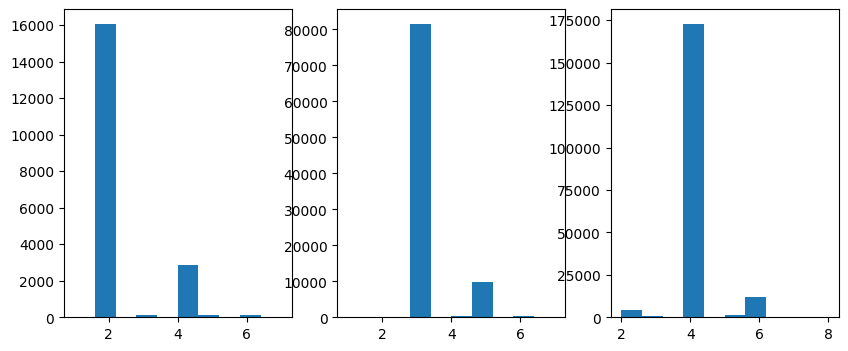

In [191]:
fig, axs = plt.subplots(1, 3, figsize=(10, 4))

for hop in hops:
    
    axs[hop-1].hist(mqa[mqa.hop == hop]["actual_hops"])

plt.show()